<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/PoissonNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Session 7

## Simulating X-ray images with specific Poisson noise using ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1)

## Author: Franck Vidal

(version 1.0, 10 Mar 2023)

# Aims of this session

1. Add Poisson noise corresponding to a given number of photons per pixel;
2. Simulate the corresponding CT scan; and
3. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/).

# Main steps

1. Simulate an X-ray projection of a Welsh dragon made of quartz

![Simulation of an X-ray projection of a Welsh dragon made of quartz](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/visualisation.png?raw=1)

2. Select the number of incident photons per pixel
3. Add the corresponding amount of Photonic noise 

![X-ray projection with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/noisy-projection.png?raw=1)

4. Simulate a CT scan

![Scanning eometry](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/CT-geometry.png?raw=1)

5. Create the flat-field images with the corresponding amount of Photonic noise

![Average flat-field image with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/average-flat-field.png?raw=1)

6. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/)

![Visualisation of the reconstructed 3D volume](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/plotCT.png?raw=1)

# Copy files

This step is needed when the notebook is executed using Goggle Collaborative

Download the Sample if needed

In [2]:
import os
import urllib.request

def createDirectory(directory):
    # The directory does not exist
    if not os.path.exists(directory):
    
        # Create the directory
        os.mkdir(os.path.abspath(directory))

def downloadFile(fname):
    if not os.path.exists(fname):
        base_url = "https://github.com/effepivi/gvxr-tutorials/raw/main"
        url = base_url + "/" + fname
        print("Download the polygon mesh (%s)" % fname)
        urllib.request.urlretrieve(url, fname)

createDirectory("JSON")
createDirectory("input_data")

downloadFile("input_data/welsh-dragon-small.stl")
downloadFile("energyResponseDetector.txt")
downloadFile("JSON/PoissonNoise.json")

# Install gVXR, k3D and imagecodecs

Run the cell below

```python
!pip3 install --upgrade gvxr k3d imagecodecs
```

In [3]:
# !pip3 install --upgrade gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git

In [4]:
from IPython.display import display
from IPython.display import Image

import matplotlib.pyplot as plt # Plotting
import numpy as np

from tifffile import imread, imwrite

from IPython.display import display
from IPython.display import Image

import SimpleITK as sitk

import matplotlib # To plot images

font = {'family' : 'serif',
         'size'   : 10
       }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)



from cil.utilities.jupyter import islicer
from cil.processors import TransmissionAbsorptionConverter
from cil.utilities.display import show_geometry, show2D
from cil.recon import FBP, FDK
from cil.plugins.astra.processors.FDK_Flexible import FDK_Flexible
    
has_tigre = True
try:
    import tigre
    print("Tigre detected")
except:
    has_tigre = False
    print("Tigre not detected")

from ipywidgets import interact
import ipywidgets as widgets

import base64

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
from gvxrPython3.JSON2gVXRDataReader import *
from gvxrPython3.utils import visualise
from gvxrPython3.utils import plotScreenshot
from gvxrPython3.utils import interactPlotPowerLaw # Plot the X-ray image using a Power law look-up table
from gvxrPython3.utils import saveProjections # Plot the X-ray image in linear, log and power law scales

Tigre detected
SimpleGVXR 2.0.5 (2023-03-09T10:48:45) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.5 (2023-03-09T10:48:44) [Compiler: GNU g++] on Linux


## Initialise GVXR using our JSON file

In [5]:
json2gvxr.initGVXR("JSON/PoissonNoise.json", renderer="EGL")

Create an OpenGL context: 500x500


Fri Mar 10 12:22:59 2023 ---- Create window (ID: -1)
Fri Mar 10 12:22:59 2023 ---- Query the number of EGL devices
Fri Mar 10 12:22:59 2023 ---- Success
Fri Mar 10 12:22:59 2023 ---- Detected 3 EGL devices.
Fri Mar 10 12:22:59 2023 ---- Print the details here of every EGL device.
Fri Mar 10 12:22:59 2023 ---- Success
Fri Mar 10 12:22:59 2023 ---- Device 1/3:
Fri Mar 10 12:22:59 2023 ---- 	Device Extensions: EGL_NV_device_cuda EGL_EXT_device_drm EGL_EXT_device_drm_render_node EGL_EXT_device_query_name EGL_EXT_device_persistent_id
Fri Mar 10 12:22:59 2023 ---- 	Device vendor: NVIDIA
Fri Mar 10 12:22:59 2023 ---- 	EGL DRM device file: /dev/dri/card0
Fri Mar 10 12:22:59 2023 ---- Device 2/3:
Fri Mar 10 12:22:59 2023 ---- 	Device Extensions: EGL_EXT_device_drm
Fri Mar 10 12:22:59 2023 ---- 	Failed to retrieve device vendor.
Fri Mar 10 12:22:59 2023 ---- 	EGL DRM device file: /dev/dri/card0
Fri Mar 10 12:22:59 2023 ---- Device 3/3:
Fri Mar 10 12:22:59 2023 ---- 	Device Extensions: EGL_MESA_d

## Create the output directory

In [6]:
raw_projection_output_dir = json2gvxr.getFilePath(json2gvxr.params["Scan"]["OutFolder"])
print("The raw projections were saved in", raw_projection_output_dir)
createDirectory(raw_projection_output_dir + "/..")
createDirectory(raw_projection_output_dir)

The raw projections were saved in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../PoissonNoise/raw_projections


## Load our detector

In [7]:
json2gvxr.initDetector("JSON/PoissonNoise.json")

Set up the detector
	Detector position: [20.0, 0.0, 0.0, 'cm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [400, 400]
	Detector number of pixels: [400, 400]
	Energy response: ../energyResponseDetector.txt in MeV
	Pixel spacing: [0.8, 0.8, 'mm']


In [8]:
number_of_rows = json2gvxr.params["Detector"]["NumberOfPixels"][1]
number_of_cols = json2gvxr.params["Detector"]["NumberOfPixels"][0]

## Load our source properties

In [9]:
json2gvxr.initSourceGeometry("JSON/PoissonNoise.json")

Set up the beam
	Source position: [-60.0, 0.0, 0.0, 'cm']
	Source shape: PointSource


In [10]:
spectrum, unit_of_energy, energy_set, bin_sets = json2gvxr.initSpectrum(verbose=0)

Fri Mar 10 12:23:03 2023 ---- Initialise the renderer


## Load our samples

In [11]:
json2gvxr.initSamples("JSON/PoissonNoise.json", verbose=1)

Load the 3D data

	Load internals in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/welsh-dragon-small.stl using mm


Fri Mar 10 12:23:03 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/welsh-dragon-small.stl	nb_faces:	457345	nb_vertices:	1372035	bounding_box (in cm):	(-4.47065, -74.9368, 23.5909)	(2.37482, -59.4256, 36.0343)


In [12]:
gvxr.moveToCentre()

ID = "root"
min_x, min_y, min_z, max_x, max_y, max_z = gvxr.getNodeAndChildrenBoundingBox(ID, "mm")
centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Bounding box:", [min_x, min_y, min_z], [max_x, max_y, max_z])
print("Bounding box centre:", [centre_x, centre_y, centre_z])

Bounding box: [-34.22738265991211, -77.55621337890625, -62.217071533203125] [34.227378845214844, 77.55621337890625, 62.217041015625]
Bounding box centre: [-1.9073486328125e-06, 0.0, -1.52587890625e-05]


## Let's get an x-ray image

We create an X-ray image `projection_in_MeV`. 
By default the image is expressed in MeV. 
We convert it to keV for display as follows: `projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")`.

In [13]:
projection_in_MeV = np.array(gvxr.computeXRayImage(), dtype=np.single)
projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")

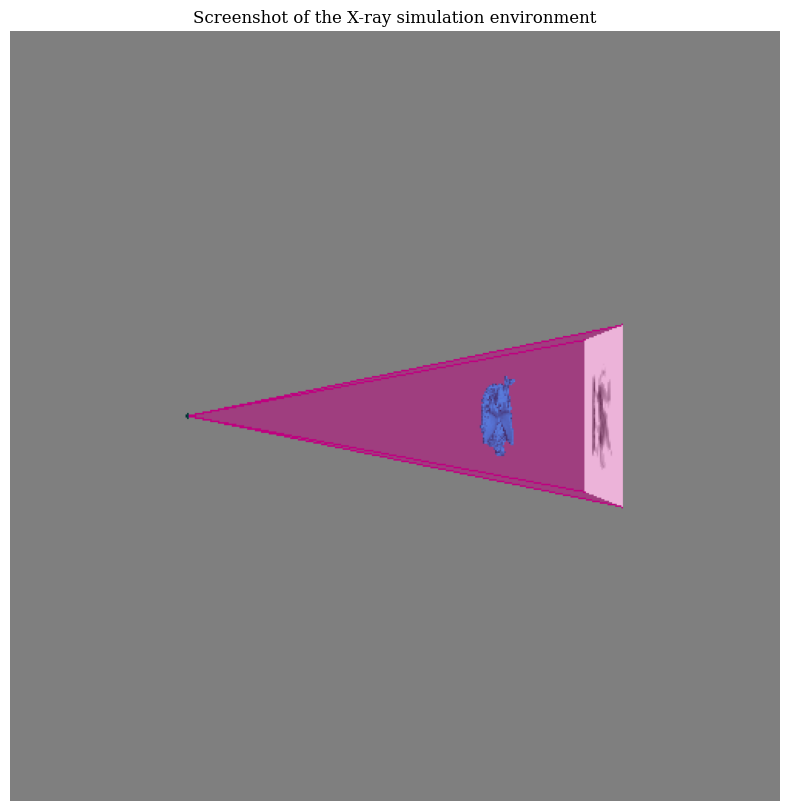

In [14]:
gvxr.displayScene()
plotScreenshot()

In [15]:
fname = raw_projection_output_dir + "/../visualisation.png"

if os.path.exists(fname):
    display(Image(fname, width=800))
else:
    plot = visualise(use_log=True)
    plot.grid_visible = False
    plot.display()

In [16]:
if not os.path.exists(fname):
    if plot is not None:
    
        plot.fetch_screenshot()

        data = base64.b64decode(plot.screenshot)
        with open(raw_projection_output_dir + "/../visualisation.png",'wb') as fp:
            fp.write(data)

## Add Poisson noise

1. Load the raw projection in the RAM
2. Convert the image in keV or MeV into number of photons
3. Add the Poisson noise
4. Convert the image in number of photons into keV or MeV
5. Apply the flat-field correction

In [17]:
def getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel):
    
    total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()
    number_of_incident_photons_per_pixel = np.sum(gvxr.getPhotonCountEnergyBins())
    energy2photons = number_of_incident_photons_per_pixel / total_energy_MeV

    temp = energy2photons / number_of_incident_photons_per_pixel * target_number_of_photons_per_pixel
    
    # Convert the image in keV into number of photons
    x_ray_image_photons = x_ray_image_energy * temp 
    
    # Add the Poisson noise
    noise_image = np.float32(np.random.poisson(x_ray_image_photons))

    # Convert in energy
    return noise_image / temp

In [18]:
fig_plot = None
def chooseNumberOfPhotonsPerPixel(xray_image: np.array, number_of_photons_per_pixel:int=15000, figsize=(10, 5)):

    """
    Use Matplotlib and a Jupyter widget to display the X-ray image with Poisson noise.
    The number of photons per pixel can be change interactively.

    @param xray_image: The image to display
    @number_of_photons_per_pixel: the number of photons per pixel (default: 15000)
    @gamma figsize: the size of the figure (default: (10, 5))
    """

    global target_number_of_photons_per_pixel, fig_plot
    target_number_of_photons_per_pixel = number_of_photons_per_pixel

    noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)

    fig_plot = plt.figure(figsize=figsize)
    ax_img = plt.subplot(111)
    img = plt.imshow(noisy_image, cmap="gray")
    # cbar = fig_plot.colorbar(img, orientation='vertical')
    title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
    ax_img.set_title(title_str)
    plt.tight_layout()
    plt.margins(0,0)

    plt.close()

    ## Callback function: plot y=Acos(x+phi)
    def update_plot(number_of_photons_per_pixel):
        global target_number_of_photons_per_pixel
        target_number_of_photons_per_pixel = number_of_photons_per_pixel
        noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)
        img = ax_img.imshow(noisy_image, cmap="gray")
        title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
        ax_img.set_title(title_str)
        # fig_plot.colorbar(img, cax=cbar.ax, orientation='vertical')

        display(fig_plot)

    interact(update_plot,
             number_of_photons_per_pixel=widgets.IntSlider(value=number_of_photons_per_pixel, min=10, max=50000, step=10, description="Photons/pixels"))

In [19]:
chooseNumberOfPhotonsPerPixel(projection_in_MeV, number_of_photons_per_pixel=5000, figsize=(10, 5))

interactive(children=(IntSlider(value=5000, description='Photons/pixels', max=50000, min=10, step=10), Output(…

In [20]:
fig_plot.savefig(raw_projection_output_dir + "/../noisy-projection.png", dpi=72)

In [21]:
print("Photons per pixels:", target_number_of_photons_per_pixel)

Photons per pixels: 5000


## Perfom the CT scan

In [22]:
angles = json2gvxr.initScan()

Set up the CT Scan


In [23]:
number_of_angles = json2gvxr.params["Scan"]["NumberOfProjections"]
angles = json2gvxr.doCTScan()

## Flat images

Create the flat field image

In [24]:
white_slider = widgets.IntSlider(value=25, min=1, max=500, step=1, description='Number of flat images:')
white_slider

IntSlider(value=25, description='Number of flat images:', max=500, min=1)

In [25]:
print("Number of flat images:", white_slider.value)

Number of flat images: 25


In [26]:
createDirectory(raw_projection_output_dir + "/../flat-field")
fname = raw_projection_output_dir + "/../flat-field/flat.tif"

total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()

temp = total_energy_MeV * np.ones([1, number_of_rows, number_of_cols], dtype=np.single)
flats = []

for i in range(white_slider.value):
    flats.append(getNoisyImage(temp, target_number_of_photons_per_pixel))

flat_field = np.average(flats, axis=0)

imwrite(fname, flat_field.astype(np.single), compression='zlib')

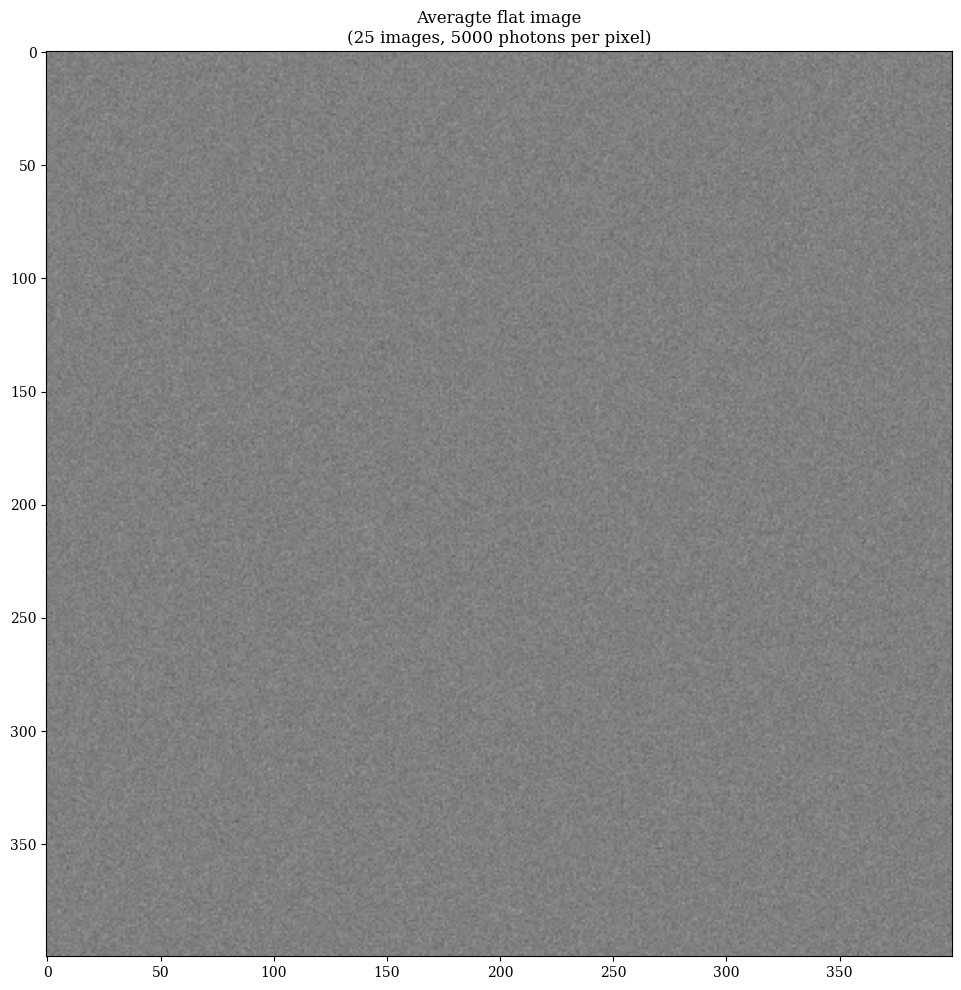

In [27]:
fig = plt.figure(figsize = (20, 10))
plt.title("Averagte flat image\n(" + str(white_slider.value) + " images, " + str(target_number_of_photons_per_pixel) + " photons per pixel)")
img = plt.imshow(flat_field[0], cmap='gray', vmin=total_energy_MeV-0.05*total_energy_MeV, vmax=total_energy_MeV+0.05*total_energy_MeV)
plt.tight_layout()
plt.savefig(raw_projection_output_dir + "/../average-flat-field.png", dpi=72)

## Add the noise to the projections

In [28]:
createDirectory(raw_projection_output_dir + "/../noiseless_projections")

raw_projections = []
for i in range(number_of_angles):

    print("Projection", i + 1, "/", number_of_angles, end='\r')

    input_fname = raw_projection_output_dir + "/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    output_fname = raw_projection_output_dir + "/../noiseless_projections/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    
    # Load the raw projection in the RAM
    x_ray_image_energy = imread(input_fname).astype(np.single)

    # Save it
    imwrite(output_fname, x_ray_image_energy)

    # Add the Poisson noise
    noise_image = getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel)

    # Flat-field
    x_ray_image_energy = noise_image / flat_field[0]
    raw_projections.append(x_ray_image_energy.astype(np.single))

    # Overwrite the image
    imwrite(input_fname, raw_projections[-1])

## CT reconstruction

In [29]:
def reconstruct(JSON_fname, verbose=0):
    
    reader = JSON2gVXRDataReader(file_name=JSON_fname)
    data = reader.read()

    if has_tigre:
        data.reorder(order='tigre')
    else:
        data.reorder("astra")

    ig = data.geometry.get_ImageGeometry()
    
    data_corr = TransmissionAbsorptionConverter(white_level=data.max(), min_intensity=0.000001)(data)

    source_shape = json2gvxr.params["Source"]["Shape"]

    if verbose > 0:
        print("Source shape:", source_shape)
    
    if type(source_shape) == str:

        if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":

            if verbose > 0: print("Parallel beam detected")

            if has_tigre:
                if verbose > 0: print("Backend: Tigre")
                reconstruction:ImageData | None = FBP(data_corr, ig).run()
            else:
                if verbose > 0: print("Backend: Astra-Toolbox")
                reconstruction:ImageData | None = FBP(data_corr, ig, backend="astra").run()

        elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":

            if verbose > 0: print("Cone beam detected")

            if has_tigre:
                if verbose > 0: print("Backend: Tigre")
                reconstruction:ImageData | None = FDK(data_corr, ig).run()
            else:
                if verbose > 0: print("Backend: Astra-Toolbox")
                fbk = FDK_Flexible(ig, data_corr.geometry)
                fbk.set_input(data_corr)
                reconstruction:ImageData | None = fbk.get_output()

        else:
            raise ValueError("Unknown source shape:" + source_shape)

    elif type(source_shape) == type([]):
        if source_shape[0].upper() == "FOCALSPOT":

            if verbose > 0: print("Cone beam with focal spot detected")
            
            if has_tigre:
                if verbose > 0: print("Backend: Tigre")
                data_corr.reorder(order='tigre')
                reconstruction:ImageData | None = FDK(data_corr, ig).run()
            else:
                if verbose > 0: print("Backend: Astra-Toolbox")
                data_corr.reorder("astra")
                fbk = FDK_Flexible(ig, data_corr.geometry)
                fbk.set_input(data_corr)
                reconstruction:ImageData | None = fbk.get_output()

        else:
            raise ValueError("Unknown source shape:" + source_shape)

    else:
        raise ValueError("Unknown source shape:" + source_shape)    
        
    return data, reconstruction

In [30]:
has_tigre = False # Make sure we use astra
data, reconstruction = reconstruct("JSON/PoissonNoise.json", verbose=1)

[400, 400]
[0.8, 0.8]
Source shape: PointSource
Cone beam detected
Backend: Astra-Toolbox


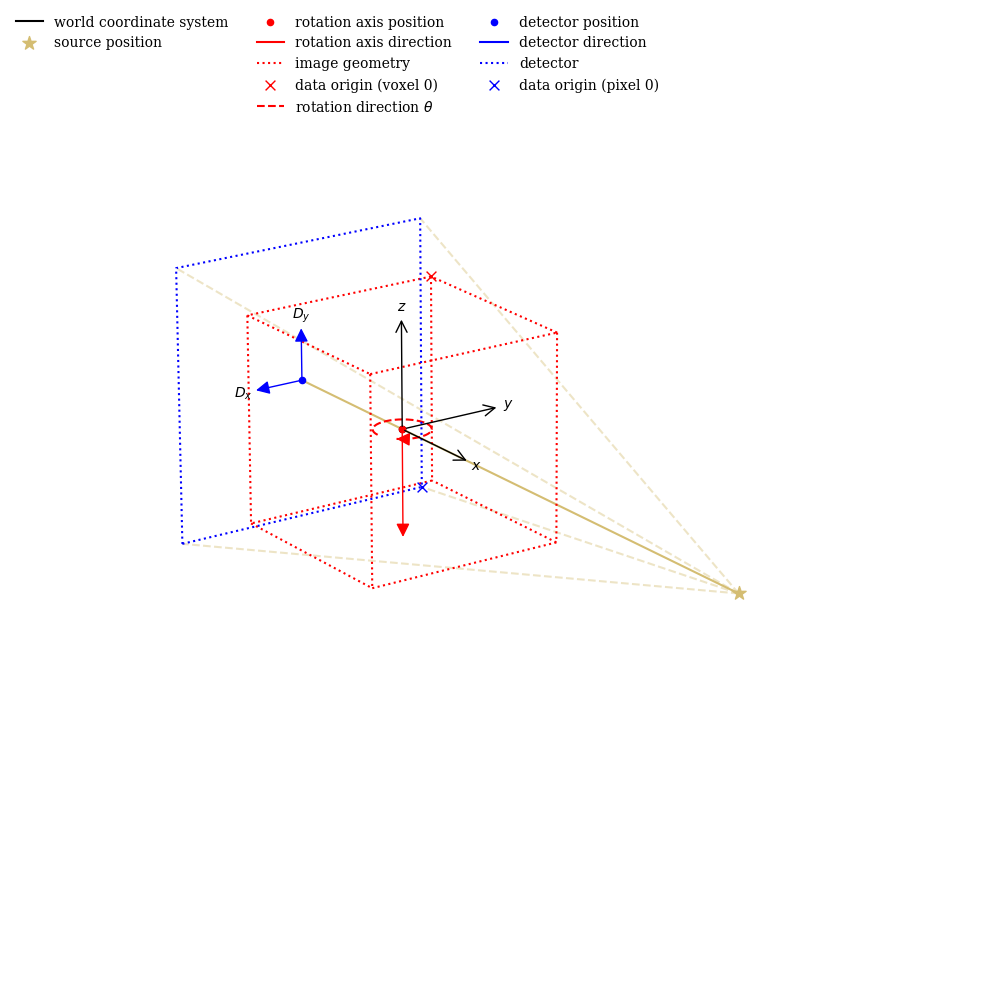

Saved image as /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/PoissonNoise/CT-geometry.png


<Figure size 640x480 with 0 Axes>

In [31]:
fig = show_geometry(data.geometry)
fig.save(raw_projection_output_dir + "/../CT-geometry.png", dpi=72)

In [32]:
islicer(reconstruction, direction='vertical')

In [33]:
islicer(reconstruction, direction='horizontal_x')

In [34]:
createDirectory(raw_projection_output_dir + "/../reconstructions")

fname = raw_projection_output_dir + "/../reconstructions/CT_in_mu.mha"

reconstruction_as_array = reconstruction.as_array()

detector_size = np.array(gvxr.getDetectorSize("mm"))
number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
spacing = detector_size / number_of_pixels
sitk_image = sitk.GetImageFromArray(reconstruction_as_array)
sitk_image.SetSpacing([spacing[0], spacing[0], spacing[1]])
sitk.WriteImage(sitk_image, fname, useCompression=True)

# del sitk_image

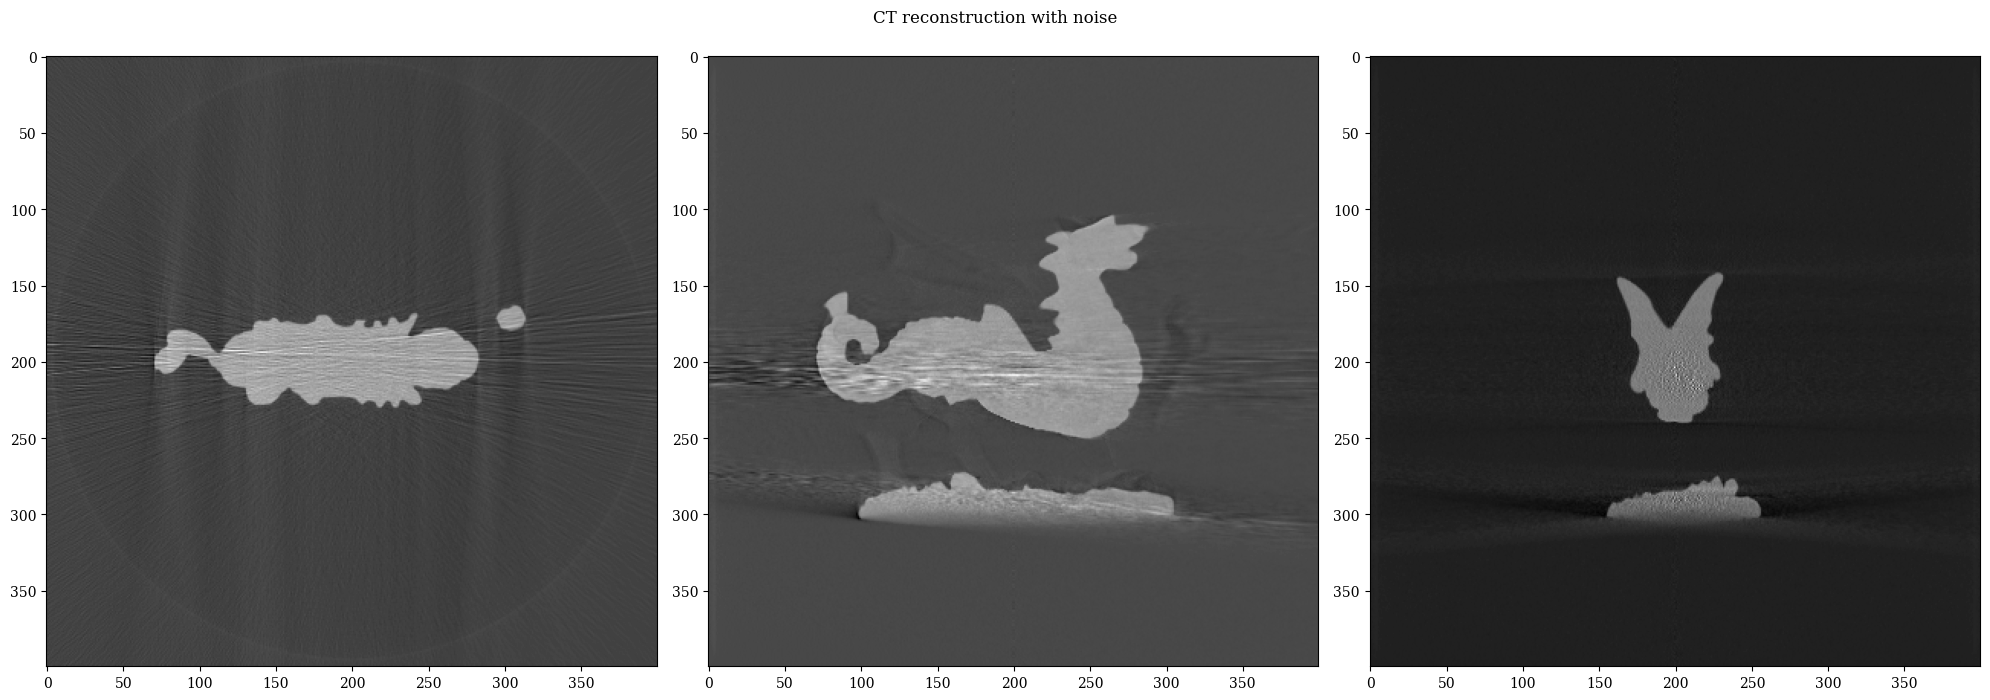

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
plt.suptitle("CT reconstruction with noise")
ax1.imshow(np.flip(reconstruction_as_array[ reconstruction_as_array.shape[0] // 2, :, :], axis=0), cmap='gray')
ax2.imshow(np.flip(reconstruction_as_array[ :, reconstruction_as_array.shape[1] // 2, :], axis=0), cmap='gray')
ax3.imshow(np.flip(reconstruction_as_array[ :, :, reconstruction_as_array.shape[2] // 2], axis=0), cmap='gray')
plt.tight_layout()
plt.savefig(raw_projection_output_dir + "/../plotCT.png", dpi=72)

# Cleaning up

Once we have finished it is good practice to clean up the OpenGL contexts and windows with the following command.

In [36]:
gvxr.terminate()

Fri Mar 10 12:23:37 2023 ---- Destroy all the windows
Fri Mar 10 12:23:37 2023 ---- Destroy window 0(0x561de0d93cb0)
